In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')

from TS_model.vizualization import PerformEDA
from TS_model.feature_engeneering import FeatureEngineer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
data = pd.read_excel('../Project 2_2023.xlsx', parse_dates=True, index_col=0)
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,income,outcome,balance
0,2017-01-09,1.343028,1.487865,-0.144836
1,2017-01-10,1.068610,1.194182,-0.125572
2,2017-01-11,0.944429,0.936663,0.007767
3,2017-01-12,1.672202,0.875379,0.796823
4,2017-01-13,0.955924,0.975645,-0.019721


In [33]:
from TS_model.anomaly_detection import UniversalChangePointDetector
#since we do not have data markup, first we run the detector for the entire history with a very hard threshold & filter the high noise level

#initialize the detector for the entire history with a very hard threshold (w/o calibrartion)
strict_threshold = 10.0
det_strict = UniversalChangePointDetector(
    threshold=strict_threshold,
    direction="both",
    season_length=1, 
    alpha=0.2, beta=0.1, gamma=0.05,
    k_mean=0.5, k_var=0.5,
    max_buffer=200,
    warmup=50
)

#collect noise
alarms_strict = []
for x in data['balance']:
    alarms_strict.append(det_strict.update(x))

#filter data to remain only normal period (alarm == False)
filtered_for_calib = [
    x for x, a in zip(data['balance'], alarms_strict) if not a
]

#detecting season length for the normal period
season_est = UniversalChangePointDetector.detect_season_length(
    filtered_for_calib
)
print(f"Detected season_length = {season_est}")

#calibrate detector with detected season_length
det_for_calib = UniversalChangePointDetector.calibrate_thr(
    filtered_for_calib,
    season_length=season_est,
    direction="both",
    alpha=0.2, beta=0.1, gamma=0.05,
    k_mean=0.5, k_var=0.5,
    max_buffer=200,
    warmup=50
)

Detected season_length = 108


In [28]:
# # пересчет баланса 
# data['balance'] = data['income'] - data['outcome']
# data.to_excel('../Project 2_2023.xlsx')

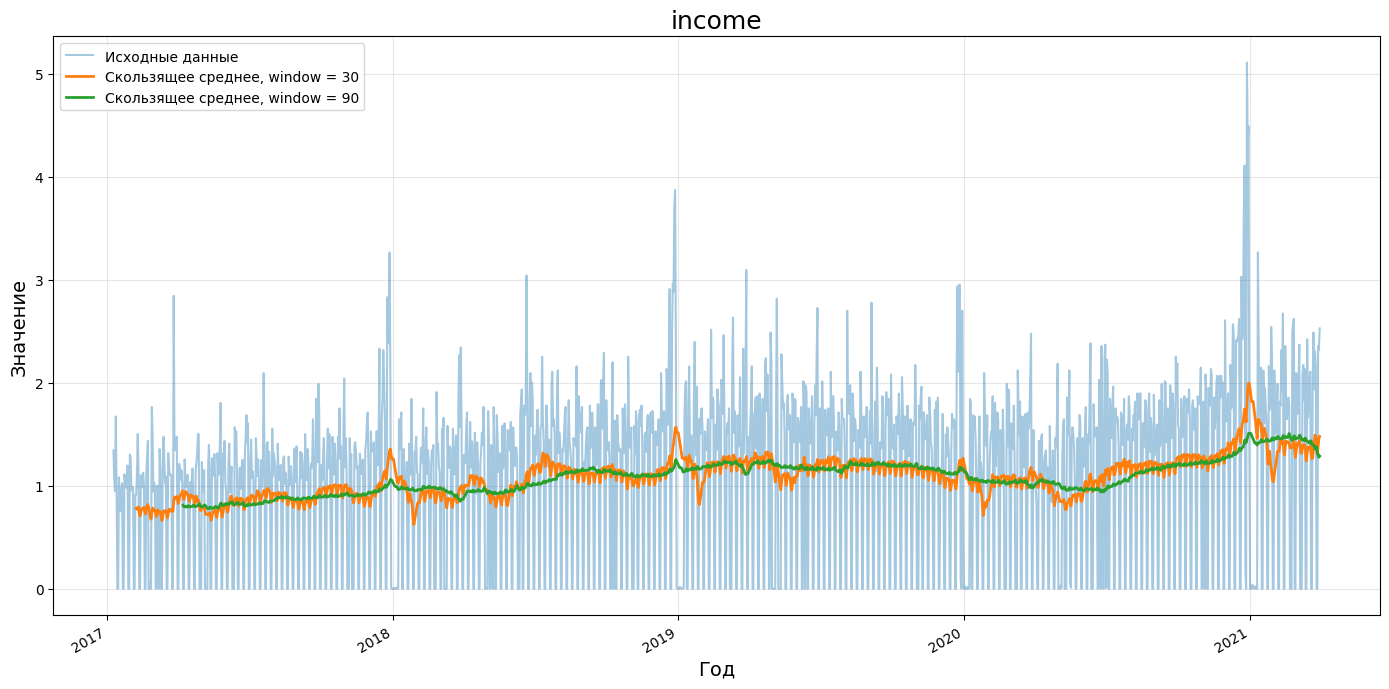

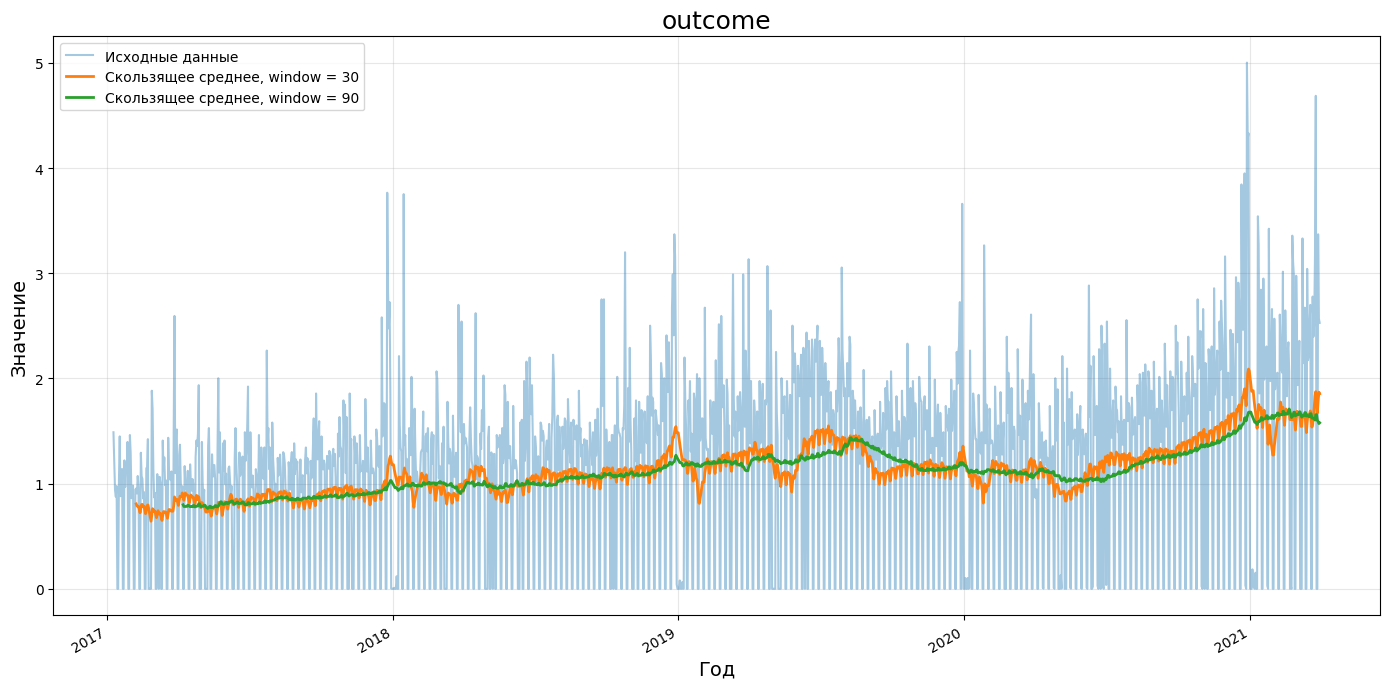

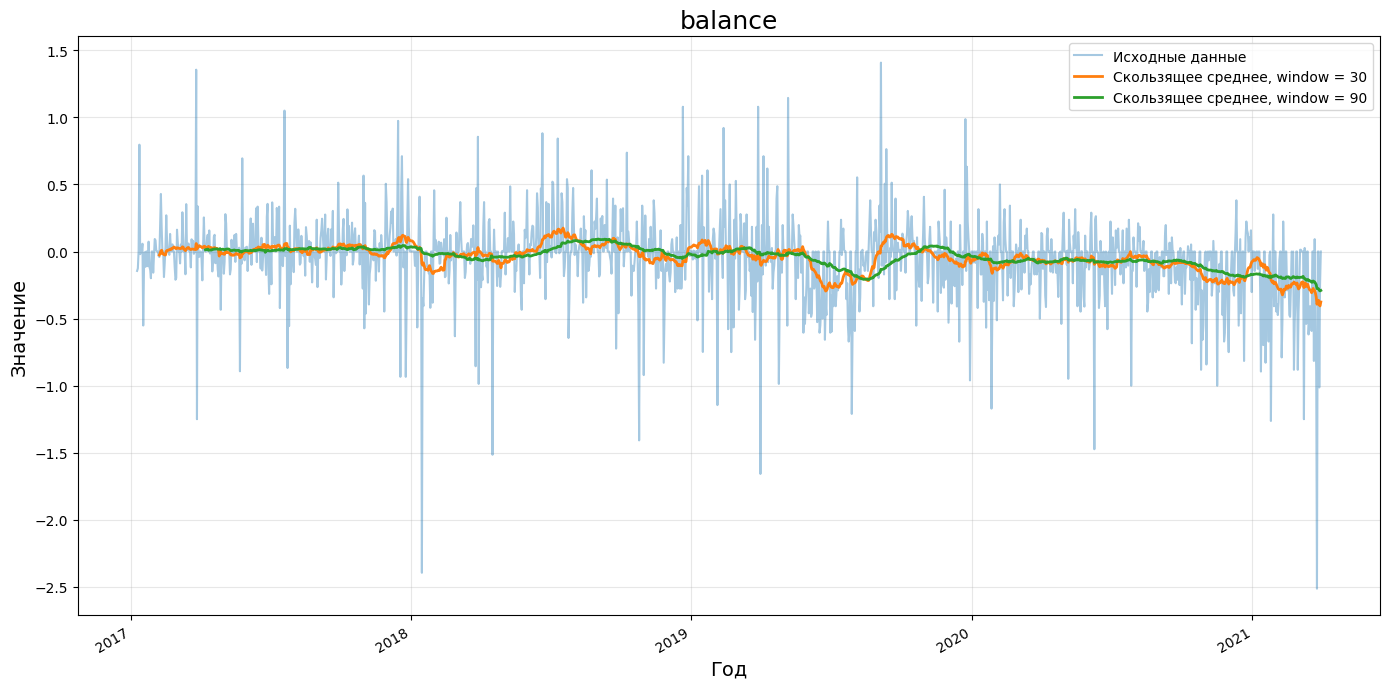

In [29]:
for col in data.copy().drop(['date'], axis=1).columns:
    PerformEDA(data=data).vizualize_var(col, windows=[30, 90])

In [30]:
feature_extactor = FeatureEngineer(data)

In [31]:
feature_extactor.add_lag_features(lags=[1, 2, 3, 7, 30, 60])
feature_extactor.add_rolling_features(windows=[3, 7, 30])
feature_extactor.add_seasonal_features()
# feature_extactor.add_special_dates() ТУТ НАДО ПЕРЕДАТЬ ДАТЫ НАЛОГОВОГО КАЛЕНДАРЯ В ФОРМАТЕ КОТОРЫЙ ЗАШИТ В МЕТОДЕ ИЛИ ПОМЕНЯТЬ МЕТОД
# add_macro_features() ДАТАФРЕЙМ МАКРО ФИЧЕЙ
data_more = feature_extactor.get_feature_df()